In [2]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.interpolate
import xarray as xr
import netCDF4 as nc4

## Create forcing files for SAL, Heat, PmE, NET_SOL.

`SST` will be the standard file to set all values to. 

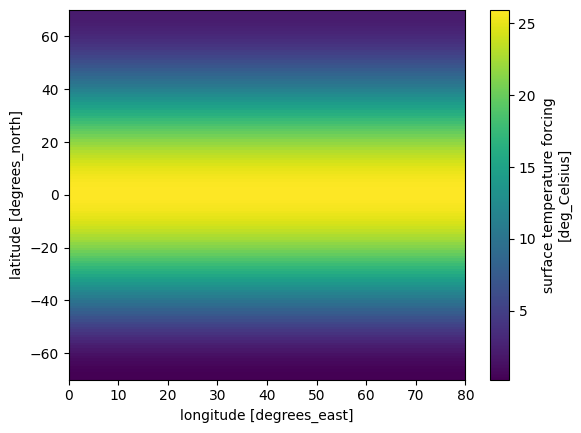

In [4]:
file_path = '/home/jupyter-kuyeda/t_m_p_wind/INPUT/'
SST = xr.open_dataset(file_path+'temp_sample_nov_17_2.nc')
SST.SST.plot()

### Make all `SST` variable name to match variables model is expecting 

In [4]:
string = ["SAL","Heat","PmE","NET_SOL"]

for i in range(0,4):
    renamed_var = SST.rename({"SST":string[i]})
    renamed_var.to_netcdf('/home/jupyter-kuyeda/t_m_p_wind/INPUT/11-27_'+string[i]+'_not_real.nc')

In [9]:
topo=xr.open_dataset('/h/kuyeda/vortex_topo_file_test1.nc')
topo

<xarray.Dataset>
Dimensions:  (xh: 80, yh: 140, xq: 81, yq: 141)
Coordinates:
  * xh       (xh) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 75.5 76.5 77.5 78.5 79.5
  * yh       (yh) float32 -69.5 -68.5 -67.5 -66.5 -65.5 ... 66.5 67.5 68.5 69.5
  * xq       (xq) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 76.0 77.0 78.0 79.0 80.0
  * yq       (yq) float32 -70.0 -69.0 -68.0 -67.0 -66.0 ... 67.0 68.0 69.0 70.0
Data variables:
    z        (yh, xh) float32 ...
Attributes:
    title:     Neverworld2 test bathymetry
    subtitle:  subtitle

In [10]:
string = ["SAL","Heat","PmE","NET_SOL"]
ds_string = ["SAL","Heat","PmE","NET_SOL"]

for i in range(0,4):
    ds_string[i] = xr.open_dataset('/home/jupyter-kuyeda/t_m_p_wind/INPUT/11-27_'+string[i]+'_not_real.nc')



for i in range(0,4):
    # get where coast is 
    nan = (ds_string[i][string[i]]).where(topo.z !=0)
    # nans
    nan.to_netcdf(file_path + '11-27_NaN_'+string[i]+'.nc')
    nan_file = xr.open_dataset(file_path + '11-27_NaN_'+ string[i]+'.nc')
    # zeros
    zero = nan_file.fillna(0)
    zero.to_netcdf(file_path + '11-27_zero_' + string[i] + '.nc')
    

In [14]:
# for temperature
nan_temp = SST.where(topo.z !=0)
nan_temp.to_netcdf(file_path + '11-27_NaN_SST.nc')

zero_temp = nan_temp.fillna(0)
zero_temp.to_netcdf(file_path + '11-27_zero_SST.nc')

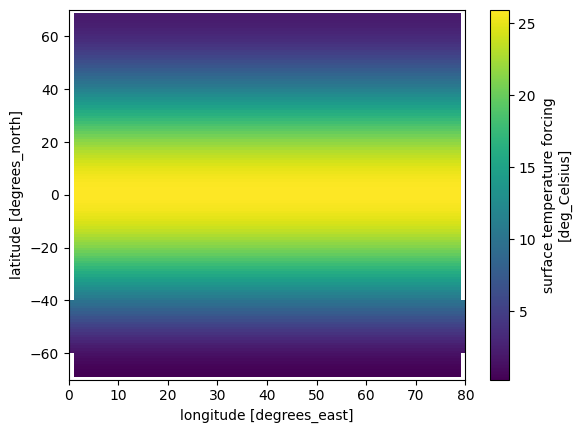

In [11]:
open_nan = xr.open_dataset(file_path + '11-27_NaN_SAL.nc')
open_nan.SAL.plot()

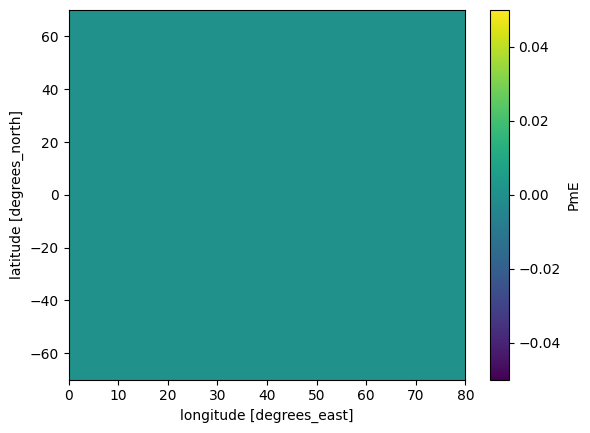

In [25]:
open_zero = xr.open_dataset(file_path + '11-27_zero_PmE.nc')
recalc = (open_zero.PmE-open_zero.PmE) / 10**4
recalc.plot()
recalc.to_netcdf(file_path + '11-29_PmE_all_zeros.nc')